### Udacity Data Science Nanodegree
### Capstone Project: Movie recommender
---
# Notebook 3: Movie Recommendation Preparation

In this notebook,
I will be applying my recommendation skills on real data blended from IMDB,
TMDB and MovieLens to build a movie recommendation web app as next step.

This notebook serves as preperation
for building and testing the webapp concepts, modules, and classes.

<img src='../images/webapp_design.png' width=800 alt='webapp_design'>

## Table of Contents

1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
   - [Univariate Exploration](#univariate)
   - [Bivariate Exploration](#bivariate)
   - [Multivariate Exploration](#multivariate)
2. [Rank Based Recommendations](#Rank)
3. [User-User Based Collaborative Filtering](#User-User)
4. [Content Based Recommendations](#Content-Recs)
5. [Matrix Factorization](#Matrix-Fact)
6. [Extras & Concluding](#conclusions)

In [1]:
# clear the garbage to free memory as we are working with huge datasets
import gc
from collections import Counter
from typing import Dict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger_eng',
               'averaged_perceptron_tagger','punkt_tab'])

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re

# custom coding
from src import *
from src import Seafoam

%matplotlib inline

# font standardization for visualization
seafoam = Seafoam()

# environment settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 42)
pd.set_option('display.width', 500)

# stock scientific notation on graphs
pd.options.display.float_format = '{:.4f}'.format

[nltk_data] Package
[nltk_data]     'averaged_perceptron_tagger_engaveraged_perceptron_tag
[nltk_data]     ger' not found in index


In [2]:
# movie id's to use for validation
hobbit_list = [903624, 2310332, 1170358]
lord_of_the_rings = [120737, 167261, 167260]
harry_potter = [241527, 295297, 304141]
love_movies = [457939]

##### Load and quick inspection of datasets

In [3]:
# get cleaned data stored in parquet format
movie_path = os.path.join('..', path_imdb_clean)
rating_path = os.path.join('..', path_ratings_clean)
# links_path = os.path.join('..', path_links_clean)
tags_path = os.path.join('..', path_tags_clean)
df_movies = pd.read_parquet(movie_path)
df_ratings = pd.read_parquet(rating_path)
df_tags = pd.read_parquet(tags_path)

In [4]:
# display a few lines of the movies dataset
df_movies.loc[df_movies['title'].str.lower().str.contains('interstellar') == True]

,title,overview,tagline,imdb_rating,imdb_votes,popularity,poster_path,release_year,last_rating_timestamp,genres,vote_average,homepage,star1,star2,star3,star4,backdrop_path
imdbId,,,,,,,,,,,,,,,,,
816692,Interstellar,The adventures of a group of explorers who mak...,Mankind was born on Earth. It was never meant ...,8.7031,2325291.0000,49.1250,https://image.tmdb.org/t/p/original/gEU2QniE6E...,2014,2023-10-12 22:40:42,"Adventure, Drama, Science Fiction",8.4531,http://www.interstellarmovie.net/,Matthew McConaughey,Anne Hathaway,Jessica Chastain,Mackenzie Foy,https://image.tmdb.org/t/p/original/pbrkL804c8...
3506492,Lolita from Interstellar Space,An undeniably beautiful alien is sent to Earth...,None,3.8008,205.0000,4.0508,https://image.tmdb.org/t/p/original/nhWlip1s5Y...,2014,NaT,Comedy,5.1992,None,None,None,None,None,None
5083736,Interstellar Wars,For millennia the Alien force has watched and ...,None,1.7002,467.0000,3.8105,https://image.tmdb.org/t/p/original/4uWZ8cdrXM...,2016,NaT,Science Fiction,3.0996,None,None,None,None,None,https://image.tmdb.org/t/p/original/wUZID3Wzrz...
5297406,Inside 'Interstellar',"Cast and crew of Christopher Nolan's ""Interste...",None,8.2031,83.0000,0.3579,https://image.tmdb.org/t/p/original/xWA7Bbo9Ve...,2015,NaT,Documentary,6.8984,None,None,None,None,None,None


In [5]:
# display a few lines of the movies dataset
df_movies.loc[df_movies['title'].str.contains('Hobbit:') == True]

,title,overview,tagline,imdb_rating,imdb_votes,popularity,poster_path,release_year,last_rating_timestamp,genres,vote_average,homepage,star1,star2,star3,star4,backdrop_path
imdbId,,,,,,,,,,,,,,,,,
903624,The Hobbit: An Unexpected Journey,"Bilbo Baggins, a hobbit enjoying his quiet lif...",From the smallest beginnings come the greatest...,7.8008,900242.0000,13.8906,https://image.tmdb.org/t/p/original/yHA9Fc37Vm...,2012,2023-10-12 22:35:16,"Adventure, Fantasy, Action",7.3555,http://www.thehobbit.com/,Martin Freeman,Ian McKellen,Richard Armitage,Andy Serkis,https://image.tmdb.org/t/p/original/xyXmtuvsoM...
1170358,The Hobbit: The Desolation of Smaug,"The Dwarves, Bilbo and Gandalf have successful...",Beyond darkness... beyond desolation... lies t...,7.8008,729622.0000,13.4688,https://image.tmdb.org/t/p/original/xQYiXsheRC...,2013,2023-10-12 16:03:28,"Fantasy, Adventure, Action",7.5703,http://www.thehobbit.com/,Ian McKellen,Martin Freeman,Richard Armitage,Ken Stott,https://image.tmdb.org/t/p/original/npCPnwDyWf...
2310332,The Hobbit: The Battle of the Five Armies,Immediately after the events of The Desolation...,Witness the defining chapter of the Middle-Ear...,7.3984,594580.0000,16.7969,https://image.tmdb.org/t/p/original/xT98tLqatZ...,2014,2023-10-12 16:03:30,"Action, Adventure, Fantasy",7.3242,https://www.warnerbros.com/movies/hobbit-battl...,Guy Pearce,None,None,None,https://image.tmdb.org/t/p/original/bVmSXNgH1g...


In [6]:
# display a few lines of the ratings dataset
df_ratings.loc[hobbit_list[0]][:5]

user_id                    15279
rating                    3.0000
timestamp    2013-02-26 23:14:14
imdbId                    215129
Name: 903624, dtype: object

In [7]:
# display a few lines of the tag dataset
df_tags.loc[[hobbit_list[0]]].T

imdbId,903624
all_texts,The Hobbit: An Unexpected Journey Bilbo Baggin...


In [8]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12097065 entries, 0 to 12097064
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   user_id    int32         
 1   rating     float16       
 2   timestamp  datetime64[ns]
 3   imdbId     int32         
dtypes: datetime64[ns](1), float16(1), int32(2)
memory usage: 207.7 MB


In [9]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46745 entries, 825671 to 33510862
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  46745 non-null  object        
 1   overview               46704 non-null  object        
 2   tagline                25362 non-null  object        
 3   imdb_rating            46745 non-null  float16       
 4   imdb_votes             46745 non-null  float32       
 5   popularity             46745 non-null  float16       
 6   poster_path            46745 non-null  object        
 7   release_year           46745 non-null  int16         
 8   last_rating_timestamp  11696 non-null  datetime64[ns]
 9   genres                 46423 non-null  object        
 10  vote_average           46745 non-null  float16       
 11  homepage               17000 non-null  object        
 12  star1                  5238 non-null   object        
 13

In [10]:
# finding specific movies for analysis
df_movies[df_movies['title'].str.lower().str.contains('lord of the rings')][
    ['title', 'release_year', 'genres']]

,title,release_year,genres
imdbId,,,
120737,The Lord of the Rings: The Fellowship of the Ring,2001,"Adventure, Fantasy, Action"
167261,The Lord of the Rings: The Two Towers,2002,"Adventure, Fantasy, Action"
167260,The Lord of the Rings: The Return of the King,2003,"Adventure, Fantasy, Action"
14824600,The Lord of the Rings: The War of the Rohirrim,2024,"Animation, Fantasy, Adventure, Action"


<a class="anchor" id="Exploratory-Data-Analysis"></a>
<h3 style="color:white; font-size:25px; text-align: left; line-height: 1;
           font-family: Calibri; background-color:#7C9E9E; border-radius:10px; padding: 14px">
           1. Exploratory Data Analysis</h3>



<a class="anchor" id="univariate"></a>
### Univariate exploration

`1.` Summary statistics

In [11]:
print('The number of unique IMDB/TMDB movies: {}'.format(df_movies.shape[0]))
print('The number of unique users who rated at least 20 movies in MovieLens: {}'.format(df_ratings.user_id.nunique()))
print('The number of unique movies that have at least 10 ratings in MovieLens: {}'.format(df_ratings.imdbId.nunique()))
print('The number of user-movie ratings in the dataset: {}'.format(df_ratings.shape[0]))
print('The number of movies that have homepages: {}'.format(df_movies.homepage.nunique()))

The number of unique IMDB/TMDB movies: 46745
The number of unique users who rated at least 20 movies in MovieLens: 96759
The number of unique movies that have at least 10 ratings in MovieLens: 11696
The number of user-movie ratings in the dataset: 12097065
The number of movies that have homepages: 16830


`2.` What is the distribution of how many movies a user rates within the dataset?

In [12]:
df_users_cnt = pd.DataFrame(
    df_ratings.groupby('user_id').size(), columns=['count']
).sort_values('count', ascending=False)
df_users_cnt.describe([0.05, 0.25, 0.5, 0.75, 0.99])

,count
count,96759.0000
mean,125.0226
std,179.0424
min,9.0000
5%,23.0000
25%,36.0000
50%,66.0000
75%,137.0000
99%,877.0000
max,6388.0000


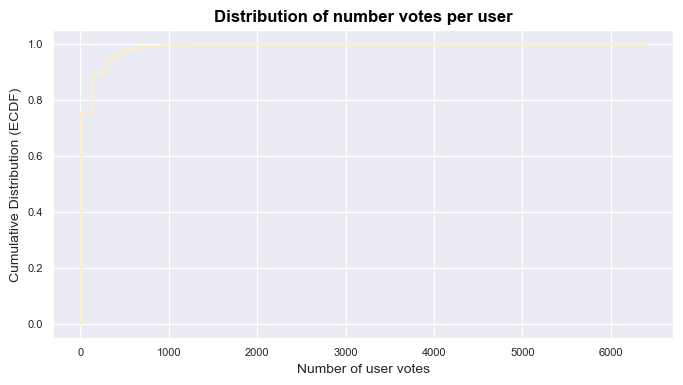

In [13]:
a = np.array(df_users_cnt['count'])
ecdf = sm.distributions.ECDF(a)
x = np.linspace(min(a), max(a))
y = ecdf(x)
plt.step(x, y, color=seafoam.base_highlight)
plt.xlabel('Number of user votes')
plt.ylabel('Cumulative Distribution (ECDF)')
plt.title('Distribution of number votes per user')
plt.show()

**Observations:** <br>
- In the IQR, users rate between 26 an 138 movies on average
- As outliers, some users rate over a 1000 movies on the 99 percentile

`3.` Most rated **movies**

In [14]:
# Display the top-ranked movies based on popularity
cols_of_interest = ['title', 'genres', 'popularity', 'imdb_votes',
                    'vote_average', 'imdb_rating']
temp = df_movies.sort_values('popularity', ascending=False)[:10][
    cols_of_interest]
temp

,title,genres,popularity,imdb_votes,vote_average,imdb_rating
imdbId,,,,,,
3566834,A Minecraft Movie,"Family, Comedy, Adventure, Fantasy",878.5000,12236.0000,6.0117,6.1016
32044730,The Codes of War,"Action, War",411.0000,110.0000,8.6016,5.3008
33397662,Saturday Night's Main Event XXXVII,Action,376.2500,145.0000,6.6992,6.5000
31691318,House of Ga'a,"Action, History",345.2500,488.0000,5.8984,3.9004
5765240,The Legend of Catclaws Mountain,"Fantasy, Family",342.7500,170.0000,6.5000,3.5000
9150192,A Working Man,"Action, Crime, Thriller",340.7500,7747.0000,6.8320,6.1016
31630905,Jake Paul vs. Mike Tyson,Action,339.2500,1466.0000,6.1992,2.9004
27812086,Cleaner,"Action, Thriller",336.5000,4522.0000,6.7578,4.8984
14513804,Captain America: Brave New World,"Action, Thriller, Science Fiction",326.5000,87027.0000,6.1211,5.8984


>**Observation**: Movies with high popularity have low IMDB ratings and votes

In [15]:
# Display the top-ranked movies based in iMDB votes
temp = df_movies.sort_values('imdb_votes', ascending=False)[:20][
    cols_of_interest]
temp

,title,genres,popularity,imdb_votes,vote_average,imdb_rating
imdbId,,,,,,
468569,The Dark Knight,"Drama, Action, Crime, Thriller",31.5469,3004728.0000,8.5156,9.0000
1375666,Inception,"Action, Science Fiction, Adventure",29.7188,2669613.0000,8.3672,8.7969
816692,Interstellar,"Adventure, Drama, Science Fiction",49.1250,2325291.0000,8.4531,8.7031
120737,The Lord of the Rings: The Fellowship of the Ring,"Adventure, Fantasy, Action",26.9219,2098115.0000,8.3984,8.8984
167260,The Lord of the Rings: The Return of the King,"Adventure, Fantasy, Action",28.9688,2068379.0000,8.5000,9.0000
1345836,The Dark Knight Rises,"Action, Crime, Drama, Thriller",14.0547,1904478.0000,7.7852,8.3984
167261,The Lord of the Rings: The Two Towers,"Adventure, Fantasy, Action",22.7500,1864543.0000,8.3984,8.7969
1853728,Django Unchained,"Drama, Western",16.3125,1780582.0000,8.1797,8.5000
172495,Gladiator,"Action, Drama, Adventure",28.5156,1749228.0000,8.2188,8.5000


In [16]:
# Display the top-ranked movies based in IMDB rating
temp = df_movies.sort_values('imdb_rating', ascending=False)[:20][
    cols_of_interest]
temp

,title,genres,popularity,imdb_votes,vote_average,imdb_rating
imdbId,,,,,,
24215588,What No One Knows,"Drama, Thriller",1.3779,79.0000,10.0000,9.7969
15030252,When the Road Ends,Documentary,1.3018,29.0000,7.0000,9.7969
34799007,Borderline Forever,"Comedy, Adventure, Music",0.5742,40.0000,10.0000,9.7969
14707514,Borderline Forever - Scott The Woz,Comedy,1.4004,1358.0000,10.0000,9.7031
12784126,StarKid Homecoming,"Music, Documentary",1.4004,41.0000,10.0000,9.7031
27798947,What is Art,Comedy,1.0859,46.0000,10.0000,9.7031
4621790,"R5: All Day, All Night","Documentary, Music",3.7148,48.0000,10.0000,9.7031
33510862,Barbenheimer and the Cult of Walt Disney,"Comedy, Adventure",0.0786,115.0000,10.0000,9.6016
26742972,Kenyatta: Do Not Wait Your Turn,Documentary,2.0195,50.0000,10.0000,9.6016


**Observation**:
- The best way to rank the top movies is to use `imdb_votes`. These movies have over 200k votes with an IMDB rating > 8.
- It is unclear how `popularity` was calculated and does not seem reliable.

`4.` Genre distribution

In [17]:
# number of different genres
genres = []
genres_unique = []
for val in df_movies['genres']:
    try:
        genres.extend(val.split(', '))
    except AttributeError:
        pass

genres_unique = set(genres)
print('The number of unique genres is: {}'.format(len(genres_unique)))
print(genres_unique)

The number of unique genres is: 19
{'War', 'Science Fiction', 'Horror', 'Comedy', 'History', 'Romance', 'Action', 'Adventure', 'Family', 'Mystery', 'Music', 'Western', 'TV Movie', 'Animation', 'Crime', 'Drama', 'Thriller', 'Fantasy', 'Documentary'}


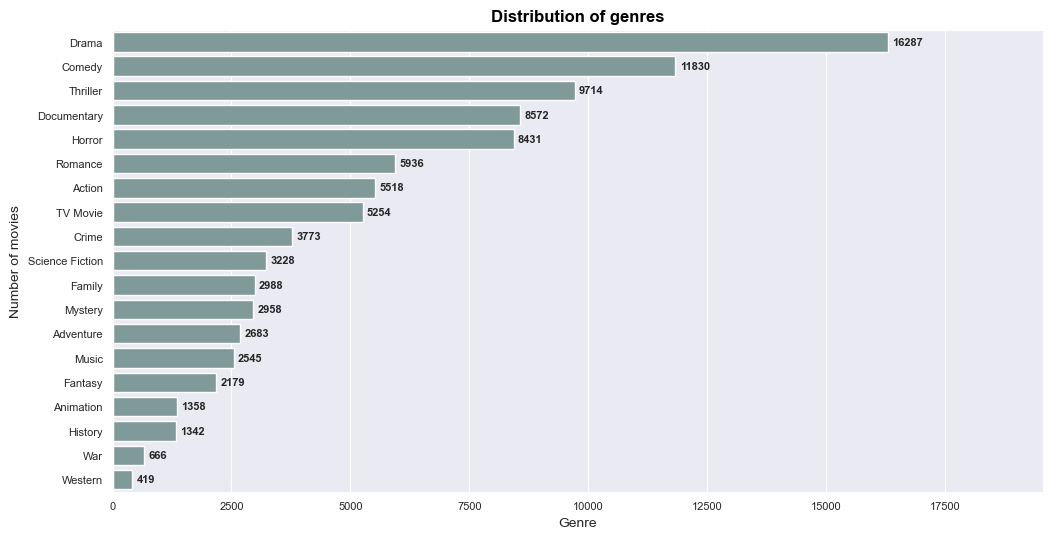

In [18]:
temp = pd.DataFrame(Counter(genres).most_common(50),
                    columns=['genre', 'count'])

fig = plt.figure(figsize=(12, 6))
ax = sns.barplot(data=temp, y='genre', x='count', color=seafoam.base_color)

# annotate
total = df_movies.shape[0]
for c in ax.containers:
    # labels = [f'{x:,.0f} ( {x / total * 100:,.0f}% )' for x in c.datavalues]
    ax.bar_label(c, padding=3, fontsize=8, weight='bold')

ax.margins(x=0.2)
# plt.xticks(rotation=90)
plt.title('Distribution of genres')
plt.ylabel('Number of movies')
plt.xlabel('Genre')
plt.show()

**Observation**:
- Movies with genres 'Drama', 'Comedy', 'Thriler' are dominating the market.

`5.` Evolution of movies released per year

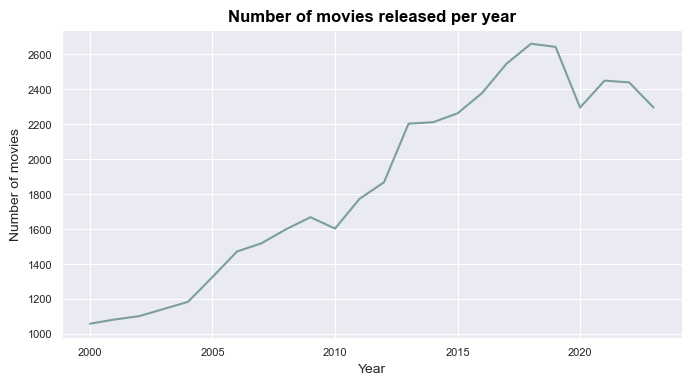

In [19]:
# quick check on evolution of movies released per year
temp = pd.DataFrame(
    df_movies.groupby('release_year').size(),
    columns=['count'])

temp = temp.loc[1990:2023]

sns.lineplot(data=temp, x=temp.index, y='count', color=seafoam.base_color)
plt.title('Number of movies released per year')
plt.ylabel('Number of movies')
plt.xlabel('Year')
plt.show()

**Observation**:
- Number of movies released per year in the scope of this project has been declining since the pandemic in 2020.
- Biggest impact, as discovered during ETL, is the change in behaviour in voting and rating.

`6.` Distribution of ratings

<a class="anchor" id="univariate"></a>
### Bivariate exploration

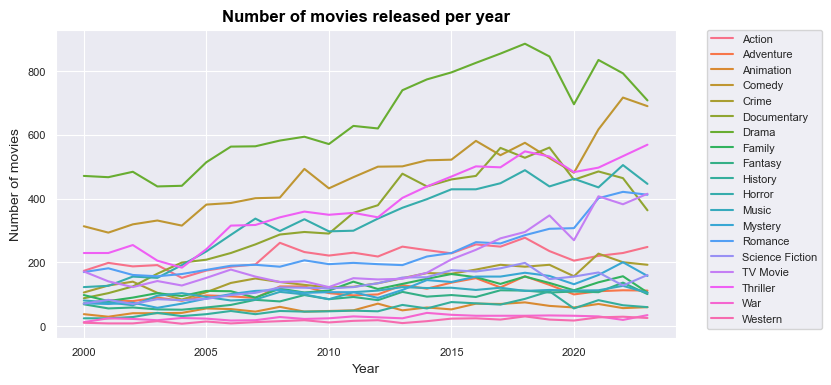

In [20]:
# quick check on evolution of movies released per year
temp = df_movies[['release_year', 'genres']].copy()
temp['genres'] = temp['genres'].str.split(', ')
temp = temp.explode('genres')

temp = pd.DataFrame(
    temp.groupby(['release_year', 'genres'], as_index=False).size(),
)

temp.set_index('release_year', inplace=True)

temp = temp.loc[1990:2023]

sns.lineplot(data=temp, x=temp.index, y='size', hue='genres',
             color=seafoam.base_color)
plt.title('Number of movies released per year')
plt.ylabel('Number of movies')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

**Observation**: Movies in the scope of this project are declining for all genres.

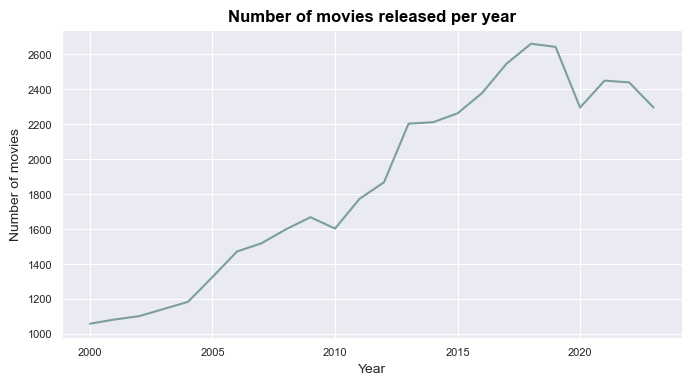

In [21]:
# quick check on evolution of movies released per year
temp = pd.DataFrame(
    df_movies.groupby('release_year').size(),
    columns=['count'])

temp = temp.loc[1990:2023]

sns.lineplot(data=temp, x=temp.index, y='count', color=seafoam.base_color)
plt.title('Number of movies released per year')
plt.ylabel('Number of movies')
plt.xlabel('Year')
plt.show()

In [22]:
## Investigate, by year, if the number of votes received
## Investigate, by year, if the average ratings

### <a class="anchor" id="Rank"></a>
<h3 style="color:white; font-size:25px; text-align: left; line-height: 1;
           font-family: Calibri; background-color:#7C9E9E; border-radius:10px; padding: 14px">
           2) Rank-Based Recommendations</h3>

The first part of our user story is,
if a user is new,
has no or less that 20 ratings, we will simply show the user the most popular movies.

We will consider what is "most popular" based on the following criteria:

* Movies with the most ratings in IMDB return the most popular movies the best, with the number of ratings over 300k
* Popular movies have a rating of at least 8 in IMDB
* If movies are tied in their number of ratings, the ranking is determined by the movie that is the most recent rating

During the wrangling step in notebook `notebooks/1_ETL_pipeline_preparation.ipynb`,
data was already cleaned-up to:
- Remove users with less than 20 ratings
- Add timestamp of latest rating for each move to the `df_movies` dataset.



In [23]:
def get_movie_contents(movies: np.array) -> Dict:
    """
    Get movie content for movies we want to recommend

    Extract the necessary columns we need to pass to the webapp

    INPUT:
    movies (np.array) -> IMBD ids of movies to recommend in order of importance

    OUTPUT:
    top_movies (Dict) -> Dict with movie ids as keys
    and movie content as values in the right sequence
    """

    cols_to_extract = ['title', 'genres', 'imdb_rating',
                       'imdb_votes', 'tagline', 'overview', 'poster_path']

    # movies are no longer sorted in order of importance
    top_movies = df_movies.loc[movies][cols_to_extract]

    # sort again in same sequence as input list
    top_movies = top_movies.loc[movies]

    top_movies['poster_path'] = 'https://image.tmdb.org/t/p/original' + \
                                top_movies['poster_path']
    top_movies['imdb_rating'] = round(top_movies['imdb_rating'], 1)
    top_movies['imdb_votes'] = top_movies['imdb_votes'].astype('int32')

    # make `imdbId` a column
    top_movies = top_movies.reset_index()

    top_movies = top_movies.to_dict(orient='index')

    return top_movies

def get_top_movies(n: int) -> Dict:
    """
    Use ranked-based recommendation to find the most popular movies

    Most popular movies are defined by the highest IMDB vote count.
    With ties, sort by the most recent rating timestamp

    INPUT:
    n - (int) the number of top articles to return

    OUTPUT:
        top_movies - (dict) Dict containing top n articles
            * key is integer in sequential order of importance
            * values contain columns needed for webapp cards
    """

    top_movies = df_movies.sort_values(
        by=['imdb_votes', 'last_rating_timestamp'],
        ascending=False)[:n]

    # get movie details and convert to dictionary
    top_movies = top_movies.index.tolist()
    top_movies = get_movie_contents(top_movies)

    # Return the top movies
    return top_movies


In [24]:
get_top_movies(n=10)

{0: {'imdbId': 468569,
  'title': 'The Dark Knight',
  'genres': 'Drama, Action, Crime, Thriller',
  'imdb_rating': 9.0,
  'imdb_votes': 3004728,
  'tagline': 'Welcome to a world without rules.',
  'overview': 'Batman raises the stakes in his war on crime. With the help of Lt. Jim Gordon and District Attorney Harvey Dent, Batman sets out to dismantle the remaining criminal organizations that plague the streets. The partnership proves to be effective, but they soon find themselves prey to a reign of chaos unleashed by a rising criminal mastermind known to the terrified citizens of Gotham as the Joker.',
  'poster_path': 'https://image.tmdb.org/t/p/originalhttps://image.tmdb.org/t/p/original/qJ2tW6WMUDux911r6m7haRef0WH.jpg'},
 1: {'imdbId': 1375666,
  'title': 'Inception',
  'genres': 'Action, Science Fiction, Adventure',
  'imdb_rating': 8.796875,
  'imdb_votes': 2669613,
  'tagline': 'Your mind is the scene of the crime.',
  'overview': 'Cobb, a skilled thief who commits corporate espi

In [25]:
top_movies = get_top_movies(20)
print('Most 20 most popular movies are:\n')
print('ID', 'Title', sep='\t\t')
for movie in top_movies.values():
    print(movie['imdbId'],
          movie['title'],
          sep='\t')

Most 20 most popular movies are:

ID		Title
468569	The Dark Knight
1375666	Inception
816692	Interstellar
120737	The Lord of the Rings: The Fellowship of the Ring
167260	The Lord of the Rings: The Return of the King
1345836	The Dark Knight Rises
167261	The Lord of the Rings: The Two Towers
1853728	Django Unchained
172495	Gladiator
993846	The Wolf of Wall Street
361748	Inglourious Basterds
372784	Batman Begins
7286456	Joker
1130884	Shutter Island
482571	The Prestige
848228	The Avengers
407887	The Departed
499549	Avatar
209144	Memento
4154796	Avengers: Endgame


In [26]:
# clear the garbage to free memory
gc.collect()

6264

<a class="anchor" id="User-User"></a>
<h3 style="color:white; font-size:25px; text-align: left; line-height: 1; font-family: Calibri; background-color:#7C9E9E; border-radius:10px; padding: 14px">3) User-User Based Collaborative Filtering</h3>

Collaborative filtering focuses on <mark>neighborhood similarities</mark>,
meaning we look for similar users to the main user
and recommend movies the main user have not watched yet,
but his closest neighbors have.

<img src="../images/collab_design.png" width=500>

Understanding how to measure the similarity of users to one another is crucial.



`1.` The function below will reformat the **df** dataframe to be shaped with users as the rows and movies as the columns.

* Each **user** should only appear in each **row** once.


* Each **movie** should only show up in one **column**.


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

#### `1.` Create test data to validate collaborative filtering recommendations

As our user story is user/customer focussed,
it's not easy to validate if similar users were found effectively.
For this reason,
let's manually find similar and opposite users to validate similarity findings.

- Generate two users that love romance but not action
- Generate two users that love action, but not romance

In [27]:
# Add genre to the rating dataset and explode it
df_movies_reduced = df_movies[['title', 'genres']]
ratings_by_genre = df_ratings.merge(df_movies_reduced,
                                    left_on='imdbId',
                                    right_index=True,
                                    how='inner')
ratings_by_genre['genres'] = ratings_by_genre['genres'].str.split(', ')
ratings_by_genre = ratings_by_genre.explode('genres')
del df_movies_reduced
ratings_by_genre.head()

,user_id,rating,timestamp,imdbId,title,genres
0,3,5.0000,2004-05-13 21:58:54,172495,Gladiator,Action
0,3,5.0000,2004-05-13 21:58:54,172495,Gladiator,Drama
0,3,5.0000,2004-05-13 21:58:54,172495,Gladiator,Adventure
1,3,3.0000,2004-05-13 21:54:24,120755,Mission: Impossible II,Adventure
1,3,3.0000,2004-05-13 21:54:24,120755,Mission: Impossible II,Action


In [28]:
# count the times each user rated a genre
users_by_genre = ratings_by_genre.groupby(['user_id', 'genres'])[
    'genres'].size().unstack()
users_by_genre.head()

genres,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,,
3,10.0000,14.0000,5.0000,11.0000,1.0000,NaN,15.0000,6.0000,5.0000,5.0000,NaN,NaN,NaN,7.0000,5.0000,NaN,3.0000,2.0000,NaN
10,222.0000,161.0000,14.0000,88.0000,72.0000,2.0000,103.0000,29.0000,77.0000,11.0000,60.0000,4.0000,50.0000,29.0000,119.0000,NaN,172.0000,14.0000,5.0000
15,6.0000,12.0000,4.0000,14.0000,3.0000,1.0000,21.0000,5.0000,9.0000,1.0000,1.0000,2.0000,2.0000,11.0000,4.0000,NaN,4.0000,1.0000,NaN
16,126.0000,60.0000,9.0000,93.0000,68.0000,1.0000,81.0000,14.0000,32.0000,7.0000,17.0000,4.0000,33.0000,40.0000,49.0000,NaN,108.0000,7.0000,2.0000
17,12.0000,5.0000,NaN,5.0000,7.0000,NaN,18.0000,NaN,3.0000,3.0000,NaN,1.0000,6.0000,4.0000,8.0000,NaN,12.0000,3.0000,NaN


In [29]:
# sort the table by the genres you want to analyze
users_by_genre.sort_values(by=['Romance', 'Action'], ascending=[False, True])[
:30]

genres,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,,
175325,884.0000,637.0000,236.0000,1990.0000,786.0000,945.0000,3242.0000,360.0000,388.0000,331.0000,787.0000,324.0000,495.0000,1095.0000,539.0000,97.0000,1469.0000,171.0000,66.0000
17035,829.0000,394.0000,53.0000,1446.0000,846.0000,85.0000,2749.0000,145.0000,259.0000,262.0000,954.0000,109.0000,614.0000,844.0000,404.0000,49.0000,1800.0000,146.0000,74.0000
95481,672.0000,559.0000,176.0000,1104.0000,402.0000,19.0000,1470.0000,391.0000,355.0000,142.0000,243.0000,112.0000,302.0000,768.0000,369.0000,38.0000,818.0000,64.0000,19.0000
7858,965.0000,684.0000,231.0000,1675.0000,644.0000,208.0000,1650.0000,421.0000,406.0000,161.0000,542.0000,144.0000,404.0000,669.0000,537.0000,125.0000,1055.0000,94.0000,40.0000
103013,118.0000,117.0000,20.0000,721.0000,264.0000,202.0000,1484.0000,40.0000,62.0000,141.0000,78.0000,75.0000,154.0000,624.0000,96.0000,16.0000,399.0000,36.0000,14.0000
159776,470.0000,558.0000,276.0000,1197.0000,213.0000,11.0000,827.0000,494.0000,385.0000,50.0000,144.0000,90.0000,183.0000,601.0000,299.0000,80.0000,346.0000,27.0000,23.0000
133878,820.0000,524.0000,122.0000,1277.0000,530.0000,185.0000,1444.0000,288.0000,269.0000,131.0000,384.0000,110.0000,271.0000,599.0000,362.0000,54.0000,882.0000,86.0000,33.0000
120892,271.0000,242.0000,46.0000,890.0000,148.0000,44.0000,699.0000,203.0000,181.0000,59.0000,127.0000,70.0000,107.0000,585.0000,175.0000,55.0000,254.0000,19.0000,6.0000
91195,891.0000,609.0000,148.0000,1266.0000,584.0000,114.0000,1613.0000,293.0000,344.0000,208.0000,368.0000,100.0000,343.0000,581.0000,443.0000,13.0000,1017.0000,109.0000,41.0000


In [30]:
# generate a fixed color for each genre,
# so different pie charts have the same meaning for a genre
genre_list = ratings_by_genre.genres.value_counts().index.to_list()
color_dict = dict(zip(genre_list, sns.color_palette("tab20", len(genre_list))))

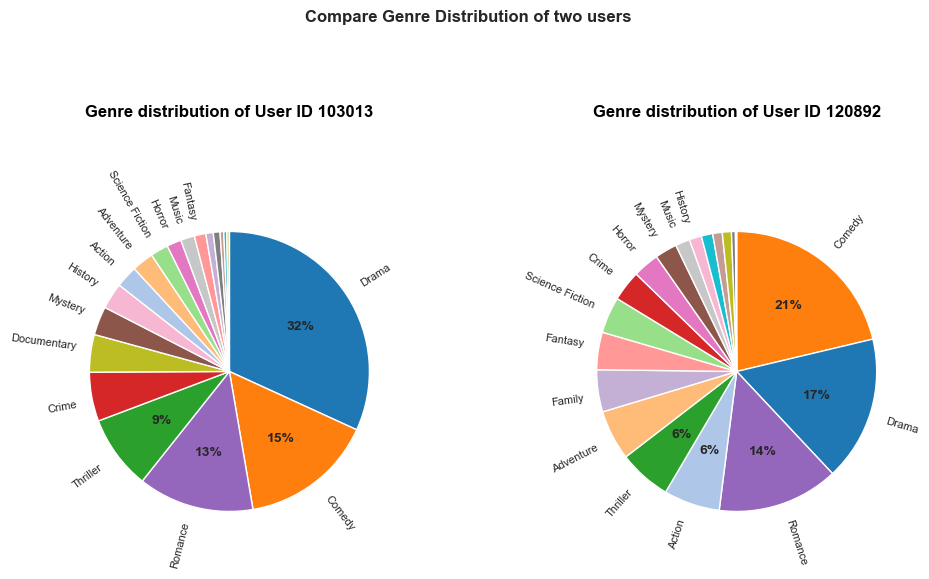

In [31]:
# Comparing users that both like romance / drama
print_pie(ratings_by_genre, users=[103013, 120892], color_dict=color_dict)

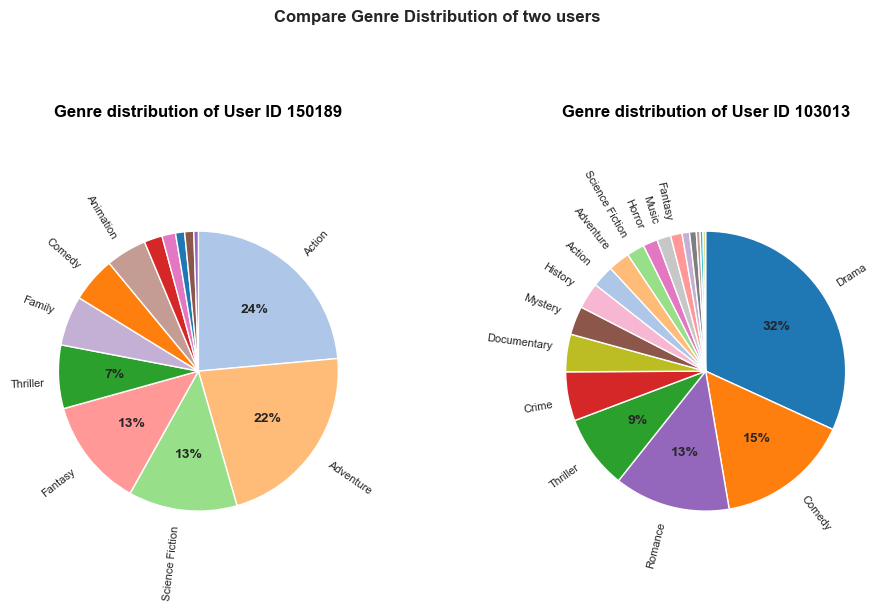

In [32]:
# Comparing romance vs action users, like me and my husband!
print_pie(ratings_by_genre, users=[150189, 103013], color_dict=color_dict,
          save=True)

In [33]:
love_users = [103013, 120892]
action_users = [150189, 30741]

In [34]:
def user_top_genre_filter(top_n):
    # Add genre to the rating dataset and explode it
    df_movies_reduced = df_movies[['imdbId', 'title', 'genres']]
    ratings_by_genre = df_ratings.merge(df_movies_reduced, on='imdbId',
                                        how='inner')
    ratings_by_genre['genres'] = ratings_by_genre['genres'].str.split(', ')
    ratings_by_genre = ratings_by_genre.explode('genres')
    del df_movies_reduced

    ratings_by_genre.head()

#### `2.` Create User_User Matrix

In [35]:
# unstack cannot work with float16, lets code around it
df_ratings_tmp = df_ratings[['user_id', 'imdbId', 'rating']]
df_ratings_tmp['rating'] = df_ratings_tmp['rating'].astype(float)
user_item = df_ratings_tmp.groupby(['user_id', 'imdbId'])[
    'rating'].max().unstack()
user_item = user_item.astype('float16')
print('Shape user-item matrix: {}'.format(user_item.shape))
del df_ratings_tmp
user_item.head()

Shape user-item matrix: (96759, 11696)


imdbId,35423,69049,113026,118141,118589,118852,118926,119004,119273,119291,120202,120352,120467,120630,120667,120679,120681,120695,120737,120753,120755,...,21929356,21940010,21991654,21994906,22042742,22494914,22687790,22750226,22769820,23571908,23648010,23950956,24068064,24223450,24248198,24509990,26739529,27141610,27155038,27430909,27726927
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0000,NaN,3.5000,NaN,3.5000,NaN,3.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# make sure matrix has the same number of rows as the number of users
assert df_ratings.user_id.nunique() == user_item.shape[0]

In [37]:
# clear the garbage to free memory
gc.collect()

20271

#### `3.` Handling data sparsity

To handle sparsity, center each user's ratings around 0,
by deducting the row average and then filling the missing values with 0.
This means missing values are replaced with neutral scores.

This is not a perfect solution as we lose interpretability,
but if we use these values only to compare users, it's ok.
Don't try to predict user ratings.


In [38]:
# Center data around 0 and fill nan with 0 to give it a neural score

# average row rating to get average ratings of users
avg_ratings = user_item.mean(axis=1)

# center the ratings
user_ratings_centered = user_item.sub(avg_ratings, axis=0)

# fill nan values with 0
user_ratings_centered = user_ratings_centered.fillna(0)

In [39]:
avg_ratings.loc[[love_users[0], action_users[0]]]

user_id
103013   3.1582
150189   3.3086
dtype: float16

In [40]:
user_ratings_centered.loc[[love_users[0], action_users[0]]]

imdbId,35423,69049,113026,118141,118589,118852,118926,119004,119273,119291,120202,120352,120467,120630,120667,120679,120681,120695,120737,120753,120755,...,21929356,21940010,21991654,21994906,22042742,22494914,22687790,22750226,22769820,23571908,23648010,23950956,24068064,24223450,24248198,24509990,26739529,27141610,27155038,27430909,27726927
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
103013,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.1582,0.0000,0.0000,0.0000,0.0000,-1.1582,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3418,0.3418,0.0000,0.0000,0.0000
150189,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.3086,0.0000,0.0000,0.0000,-2.3086,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [41]:
# clear the garbage to free memory
gc.collect()

10

#### `3.` Find the closest neighbor for a user, calculating similarities with cosine (item_based)
Because we centered the data around 0,
the cosine values will range from -1 to 1.
1 means it's the most similar, -1 means its the least similar


In [42]:
# find closest neighbors for a specific user
input_user_series = user_ratings_centered.loc[love_users[0]].values.reshape(1,
                                                                            -1)

user_similarities = cosine_similarity(
    input_user_series,
    user_ratings_centered
)

# convert to dataframe so we know which users we are comparing
user_similarities_df = pd.DataFrame(user_similarities,
                                    columns=user_ratings_centered.index,
                                    )

knn = user_similarities_df.loc[0].to_frame(name='similarity')
knn['similarity'] = round(knn['similarity'], 4)
knn = knn.sort_values(by='similarity', ascending=False)[1:200]
knn = knn.reset_index(names='user_id')
knn.head()

,user_id,similarity
0,2704,0.1557
1,93211,0.1459
2,163910,0.1437
3,169856,0.1436
4,154244,0.1433


Now lets sort the closest neighbors in order of who rated the most movies

In [43]:
# Count the number of times a user rated movies
num_user_ratings = df_ratings.groupby('user_id')['rating'].size()
num_user_ratings.loc[2704]

1196

In [44]:
# get number of votes per neighbor and sort
knn['num_votes'] = knn.user_id.apply(
    lambda x: num_user_ratings.loc[x]).squeeze().astype(float)
knn = knn.sort_values(by=['similarity', 'num_votes'], ascending=[False, False])
knn.head(10)

,user_id,similarity,num_votes
0,2704,0.1557,1196.0000
1,93211,0.1459,2058.0000
2,163910,0.1437,710.0000
3,169856,0.1436,898.0000
4,154244,0.1433,544.0000
5,162621,0.1432,2215.0000
6,135933,0.1426,1538.0000
7,13492,0.1417,2347.0000
8,112246,0.1416,1226.0000
9,119120,0.1411,1123.0000


#### `4.` Evaluate closest neighbors

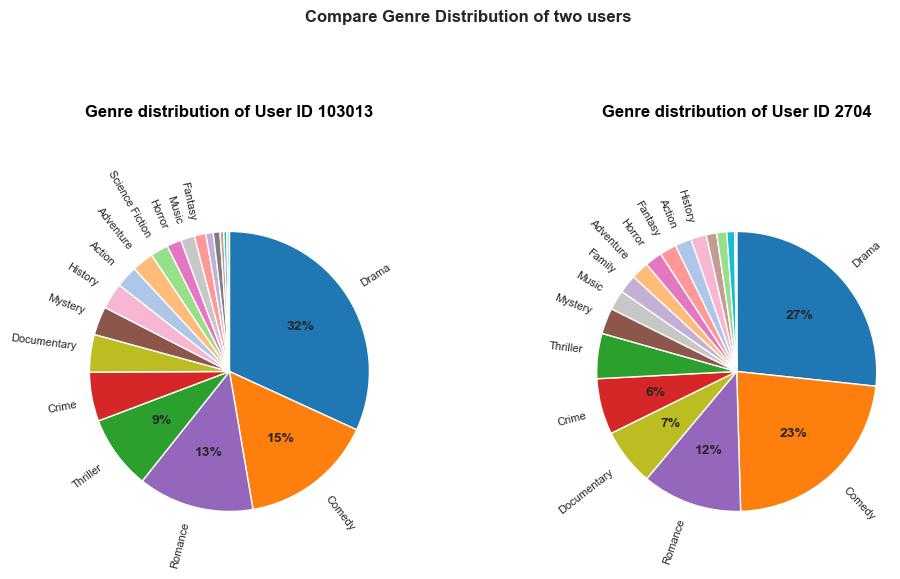

In [45]:
# pie chart for our input user we try to find neighbors for
print_pie(ratings_by_genre, users=[love_users[0], 2704], color_dict=color_dict,
          save=False)

<div class="tenor-gif-embed" data-postid="20030821" data-share-method="host" data-aspect-ratio="1" data-width="30%"><a href="https://tenor.com/view/it-worked-rupaul-late-night-with-seth-meyers-yes-finally-gif-20030821">It Worked Rupaul GIF</a>from <a href="https://tenor.com/search/it+worked-gifs">It Worked GIFs</a></div> <script type="text/javascript" async src="https://tenor.com/embed.js"></script>

##### `5.` Above proof-of-concept is working well, lets refactor for use in the webapp

In [46]:
def create_user_item_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a user-user matrix we can use for similarity calculations

    Return a matrix with user ids as rows and movie ids as columns
    and ratings as the values.

    To handle sparsity, center each user's ratings around 0,
    by deducting the row average and then filling the missing values with 0.
    This means missing values are replaced with neutral scores.

    This is not a perfect solution as we lose interpretability,
    but if we use these values only to compare users, it's ok.
    Don't try to predict user ratings.

    INPUT:
    df - pandas dataframe containing user id, movie id, and rating

    OUTPUT:
    user_item - user item matrix
                - with users as index
                - movies as columns
                - ratings as values
    """

    # unstack cannot work with float16, lets code around it
    df_ratings_tmp = df[['user_id', 'imdbId', 'rating']]
    df_ratings_tmp['rating'] = df_ratings_tmp['rating'].astype(float)

    # build the user-item matrix
    user_item = df_ratings_tmp.groupby(['user_id', 'imdbId'])[
        'rating'].max().unstack()

    # reduce memory usage
    user_item = user_item.astype('float16')

    # To handle sparsity, center data around 0 and fill nan with 0 to give it a neural score
    # Get average row rating to get average ratings of users
    avg_ratings = user_item.mean(axis=1)

    # center the ratings
    user_item_centered = user_item.sub(avg_ratings, axis=0)

    # fill nan values with 0
    user_item_centered = user_item_centered.fillna(0)

    del df_ratings_tmp

    return user_item_centered

In [47]:
# create user-item matrix
user_item = create_user_item_matrix(df_ratings)
assert user_item.isna().sum().sum() == 0

In [48]:
def count_user_ratings(df: pd.DataFrame) -> pd.Series:
    """
    Calculate the total number of times each user rated movies

    Input:
    df - pandas dataframe containing all the movie ratings

    Output:
    num_user_ratings - pandas series containing total votes per user
                         * index = user_id
                         * value: total times movies were rated
    """

    num_user_ratings = df_ratings.groupby('user_id')[
        'rating'].size().sort_values(ascending=False)

    return num_user_ratings


def count_movie_ratings(df: pd.DataFrame) -> pd.Series:
    """
    Calculate the total number of times each movie was rated

    Input:
    df - pandas dataframe containing all the movie ratings

    Output:
    num_user_ratings - pandas series containing total votes per user
                         * index = movie id
                         * value: total times movies were rated
    """

    num_movie_ratings = df_ratings.groupby('imdbId')[
        'rating'].size().sort_values(ascending=False)

    return num_movie_ratings

In [49]:
# calculate the total number of ratings per users and movies
num_user_ratings = count_user_ratings(df_ratings)
num_movie_ratings = count_movie_ratings(df_ratings)
num_movie_ratings.head()

imdbId
120737     61710
167261     57590
167260     57495
468569     50476
1375666    49887
Name: rating, dtype: int64

In [50]:
def find_similar_users(user_id: int,
                       user_item: pd.DataFrame = user_item,
                       num_user_ratings: pd.DataFrame = num_user_ratings,
                       top_n: int = 200
                       ) -> pd.DataFrame:
    """
    Find the nearest neighbors for an input user using cosine similarity

    Sort neighbors by cosine similarity and their number of total votes

    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    knn - (pandas Dataframe) with columns:
        * index (int): incremental counter showing in order of neighbor importance
        * user_id (int): unique user id assigned to each neighbor
        * similarity (float): cosine similarity score rounded to 4 decimals
        * num_user_ratings (int): total number of votes per user (for all movies)
    """

    # find closest neighbors for a user
    input_user_series = user_item.loc[user_id].values.reshape(1, -1)

    user_similarities = cosine_similarity(
        input_user_series,
        user_item,
    )

    user_similarities_df = pd.DataFrame(user_similarities,
                                        columns=user_item.index,
                                        )

    # get top similar users and format ready to find the number of votes
    knn = user_similarities_df.loc[0].to_frame(name='similarity')
    knn['similarity'] = round(knn['similarity'], 4)
    knn = knn.sort_values(by='similarity', ascending=False)[1:top_n]
    knn = knn.reset_index(names='user_id')

    # get the total number of votes for each neighbor and sort
    knn['num_votes'] = knn.user_id.apply(
        lambda x: num_user_ratings.loc[x]).squeeze()
    knn = knn.sort_values(by=['similarity', 'num_votes'],
                          ascending=[False, False])
    return knn

In [51]:
# Spot-check function using cosine similarity
print("The most similar users to user {} are: \n\n{}".format(
    love_users[0],
    find_similar_users(
    love_users[0])))

print("\n\nThe most similar users to user 93211 are: \n{}".format(
    find_similar_users(93211)[:10]))

print("\n\nThe most similar users to user {} are: \n{}".format(
    action_users[0],
    find_similar_users(action_users[0])))

The most similar users to user 103013 are: 

     user_id  similarity  num_votes
0       2704      0.1557       1196
1      93211      0.1459       2058
2     163910      0.1437        710
3     169856      0.1436        898
4     154244      0.1433        544
..       ...         ...        ...
194   117964      0.0974        440
198    15489      0.0973       1301
197   192924      0.0973        803
195   117322      0.0973        468
196   138538      0.0973        301

[199 rows x 3 columns]


The most similar users to user 93211 are: 
   user_id  similarity  num_votes
0   162621      0.2382       2215
1   119120      0.2303       1123
2   133756      0.2250       1099
3     9085      0.2244       2876
4   135933      0.2202       1538
5    35980      0.2202       1505
6   116907      0.2163       2101
7   147603      0.2143       2440
8   169856      0.2085        898
9   112246      0.2078       1226


The most similar users to user 150189 are: 
     user_id  similarity  num_vote

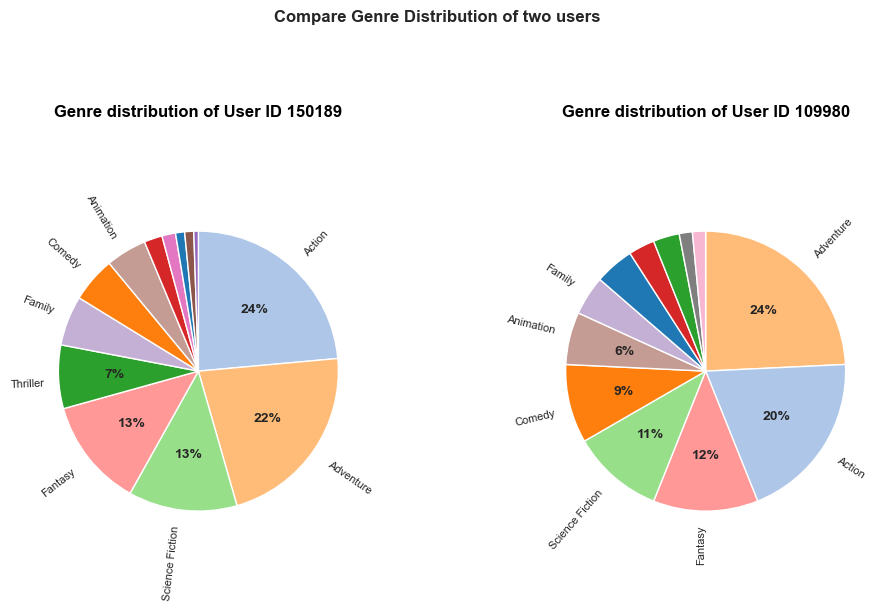

In [52]:
# pie chart for input action users
print_pie(ratings_by_genre,
          users=[action_users[0], 109980],
          color_dict=color_dict, save=True)

`6.` Now that we have a function that find the most similar users, let's use these users to find movies to recommend.

The below functions will return the movies to recommend to a user.

In [53]:
def get_movies_watched(user_id: str) -> np.array:
    """
    Get movies a user has seen already (based on ratings)

    Movies will be sorted by highest ratings and then the latest timestamp.

    INPUT:
    user_id: int -> Id of a user

    OUTPUT:
    List -> sorted list of movie_id's a user has seen in order of importance
    """

    movies_watched = df_ratings[df_ratings['user_id'] == user_id]
    movies_watched['rating'] = movies_watched['rating'].astype(float)
    movies_watched = movies_watched.sort_values(by=['rating', 'timestamp'],
                                                ascending=False)
    movies_watched = np.array(movies_watched['imdbId'])

    return movies_watched

In [54]:
def user_user_recommendations(user_id: int, top_n: int=10,) -> Dict:
    """
    Get top movies to recommend to user

    Steps:
    1) Get movies the input user has watched
    2) Get the closest neighbors user_id
    3) Start with the first neighbor:
       3.1) Get the list of movies the neighbor watched in order of importance
       (rating given by the neighbor and the latest timestamp)
       3.2) Remove movies already watched by input user
       3.3) Add movies in the order of importance to a recommendation list
       3.4) Continue down the list until top_n movies are found
    4) Get movie columns we need to pass to the webapp
    5) Convert to dictionary

    Following the steps above
    means we could end up recommending the movies from the top neighbor only!
    (Which is ok)

    INPUT:
    user_id - (int) a user id
    top_n - (int) the number of movies to recommend
    
    OUTPUT:
        top_articles - (dict) Dict containing top n articles
            * key is integer in sequential order of importance
            * values contain columns needed for webapp cards
    """

    # list of movies to recommend
    recs = []

    # Get movies input user has watched, or order of importance
    input_movies_watched = get_movies_watched(user_id)

    # get nearest neighbors
    neighbors_df = find_similar_users(user_id)

    for neighbor in neighbors_df['user_id'].tolist():

        # get movies the neighbor watched, in order of importance
        neighbor_movies_watched = get_movies_watched(neighbor)

        # remove movies input user watched
        mask = ~np.isin(neighbor_movies_watched, input_movies_watched)
        new_recs = neighbor_movies_watched[mask]

        # add articles to our recommendation list
        recs.extend(new_recs)

        # stop if recommendations exceed the number of required recommendations
        if len(recs) >= top_n:
            break

    # Select only the top_n
    recs = recs[:top_n]

    top_movies = get_movie_contents(recs)

    return top_movies

In [55]:
# Let's try to test this function
# Movie recommendation for a user who loves romance and drama
# user_user_recommendations(love_users[0])
top_movies = user_user_recommendations(love_users[0], 15)
print('Most 20 most popular movies are:\n')
print('ID', 'Title', sep='\t\t\t')
for movie in top_movies.values():
    print(movie['imdbId'],
          movie['title'],
          sep='\t\t\t')


Most 20 most popular movies are:

ID			Title
318411			The Magdalene Sisters
839739			The Beales of Grey Gardens
2714900			Finding Vivian Maier
218839			Best in Show
146882			High Fidelity
435761			Toy Story 3
239894			Paradise Lost 2: Revelations
243664			Wit
266543			Finding Nemo
374900			Napoleon Dynamite
1049413			Up
1725969			Ethel & Ernest
3417870			The Price of Gold
865297			The Black Balloon
168629			Dancer in the Dark


In [56]:
# user_user_recommendations(love_users[0])
top_movies = user_user_recommendations(103013, 1)
top_movies[0]['imdbId']

318411

In [57]:
# Movie recommendation for a user who loves action
top_movies = user_user_recommendations(action_users[0], 15)
print('Most 20 most popular movies are:\n')
print('ID', 'Title', sep='\t\t\t')
for movie in top_movies.values():
    print(movie['imdbId'],
          movie['title'],
          sep='\t\t\t')

Most 20 most popular movies are:

ID			Title
4633694			Spider-Man: Into the Spider-Verse
8367814			The Gentlemen
478970			Ant-Man
241527			Harry Potter and the Philosopher's Stone
1431045			Deadpool
1049413			Up
948470			The Amazing Spider-Man
2250912			Spider-Man: Homecoming
7286456			Joker
5463162			Deadpool 2
8579674			1917
6320628			Spider-Man: Far From Home
2084970			The Imitation Game
480249			I Am Legend
443453			Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan


<div class="tenor-gif-embed" data-postid="3072513639493954552" data-share-method="host" data-aspect-ratio="0.595556" data-width="20%"><a href="https://tenor.com/view/taylor-swift-eras-tour-taylor-taylor-swift-taylor-swift-smile-taylor-swift-cute-gif-3072513639493954552">Taylor Swift Eras Tour Taylor Swift Smile GIF</a>from <a href="https://tenor.com/search/taylor+swift+eras+tour-gifs">Taylor Swift Eras Tour GIFs</a></div> <script type="text/javascript" async src="https://tenor.com/embed.js"></script>

In [58]:
# clear the garbage to free memory
gc.collect()

18885

<a class="anchor" id="Content-Recs"></a>
<h3 style="color:white; font-size:25px; text-align: left; line-height: 1; font-family: Calibri; background-color:#7C9E9E; border-radius:10px; padding: 14px">4) Content Based Recommendations</h3>

Another method we can use to make recommendations is
to recommend documents with the highest text-based cosine similarity to an input search term.

Use NLP techniques to convert document texts into words.

In [59]:
# A reminder, all text columns were accumulated into the below dataset,
# column 'all_text' is a summary of all text
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46745 entries, 825671 to 33510862
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   all_texts  46745 non-null  object
dtypes: object(1)
memory usage: 1.3+ MB


In [60]:
def tokenize(text):
    """ Summarize text into words whilst cleaning it up

    Most important functions:
    - Summarize url links starting with http or www to a common phrase 'url
    - Summarize email addresses to a common phrase 'email'
    - Get rid of new lines `\n'
    - Remove all words that are just numbers
    - Remove all words that contain numbers
    - Cleanup basic punctuation like '..', '. .'
    - Remove punctuation
    - Remove words that are just 1 character long after removing punctuation
    - Use lemmatization to bring words to the base

    Args:
        text: string, Text sentences to be split into words

    Return:
        clean_tokens: list, List containing most crucial words
    """

    # Replace urls starting with 'https' with placeholder
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    # replace urls with a common keyword
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'url')

    # Replace urls starting with 'www' with placeholder
    url_regex = 'www.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'url')

    # replace emails with placeholder
    email_regex = '([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})'
    detected_emails = re.findall(email_regex, text)
    for email in detected_emails:
        text = text.replace(email, 'email')

    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")
    text = text.replace("\r", " ")
    text = text.replace("..", ".")
    text = text.replace(". .", ".")
    text = text.replace(" ,.", ".")

    text = re.sub(r'\s+', ' ', text).strip()

    # normalize text by removing punctuation, remove case and strip spaces
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = text.lower().strip()

    # remove numbers
    text = re.sub(r'\d+', '', text)

    #  split sentence into words
    tokens = word_tokenize(text)

    # Remove stopwords, e.g. 'the', 'a',
    tokens = [w for w in tokens if w not in stopwords.words("english")]

    # take words to their core, e.g. children to child, organizations to organization
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok, wordnet.VERB)
        # ignore tokens that have only 1 character or contains numbers
        if len(clean_tok) >= 2 & clean_tok.isalpha():
            clean_tokens.append(clean_tok)

    return clean_tokens

In [61]:
def create_word_count_matrix(df, column='all_texts', max_features=5000, min_df=3, max_df=0.6):
    """
    Create a word count matrix for a dataframe column containing text

    Input:
    df: pandas dataframe containing text
    column: string -> column to convert to word counts

    Output:
    tfidf_df: pandas dataframe containing the word count matrix

    """
    # df.set_index('article_id', inplace=True)

    # Create a word count matrix by article
    tfidf_vectorizer = TfidfVectorizer(
        min_df=min_df,
        max_df=max_df,
        tokenizer=tokenize,
        token_pattern=None,
        max_features=max_features)

    vectorized_data = tfidf_vectorizer.fit_transform(df[column])
    tfidf_df = pd.DataFrame(vectorized_data.toarray(),
                            columns=tfidf_vectorizer.get_feature_names_out(),
                            index=df.index)

    return tfidf_df, tfidf_vectorizer

In [62]:
tfidf_df, tfidf_vectorizer = create_word_count_matrix(
    df=df_tags,
    column='all_texts'
)
tfidf_df.head()

,aaron,abandon,abby,abduct,abduction,abigail,abilities,ability,able,abortion,abraham,abrams,abroad,absorb,absurd,absurdism,absurdist,abuse,abusive,academy,accent,...,york,young,younger,youth,youtube,z,zac,zach,zachary,zack,zealand,zellweger,zerneck,zero,zimmer,zoe,zombie,zombies,zone,zoo,zooey
imdbId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
825671,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0950,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
266543,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0026,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
168629,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
411267,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1076,0.0000,0.0000,0.0000,...,0.0000,0.0639,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
314412,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [63]:
# which words are used the most?
tfidf_df.sum(axis=0).sort_values(ascending=False)[:20]

film            1273.1169
comedy          1026.2564
drama           1014.0099
documentary      955.3047
productions      834.2780
horror           822.3049
thriller         770.2874
family           750.7863
life             749.6947
entertainment    733.1967
one              706.7426
love             673.4620
picture          669.4173
find             668.1449
new              659.0916
movie            653.0273
romance          627.3210
world            609.5863
live             607.7355
story            596.2199
dtype: float64

In [64]:
def make_content_recommendations(
        tfidf_df: pd.DataFrame,
        tfidf_vectorizer: TfidfVectorizer(),
        input_search_text: str,
        user_id: int,
        top_n=10) -> Dict:
    """
    Content-based recommendations based on text-based similarity

    User input any search text

    INPUT:
    input_search_text: string, any text a user input to search for documents
    user_id: integer, id of the user we make recommendations for
    tfidf: pandas dataframe containing the word count matrix
    tfidf_vectorizer: word count model,
    to vectorize user input to the same standard

    OUTPUT:
        top_articles - (dict) Dict containing top n articles
            * key is integer in sequential order of importance
            * values contain columns needed for webapp cards
    """

    top_movies = {}

    # convert input text to the fitted tfidf model
    input_search_text = (
        tfidf_vectorizer.transform([input_search_text]))

    # find cosine similarity between the input search text to each document
    similarity = cosine_similarity(input_search_text, tfidf_df)
    cosine_similarity_df = pd.DataFrame(
        similarity,
        columns=tfidf_df.index)

    # get the most similar records, ranked by the highest similarity
    cosine_similarity_df = cosine_similarity_df.loc[0].sort_values(
        ascending=False).reset_index()

    # to handle ties, sort by similarity and number of IMDB votes
    df_temp_movies = df_movies[['imdb_votes']]
    cosine_similarity_df = cosine_similarity_df.merge(df_temp_movies, on='imdbId', how='left').fillna(0)
    cosine_similarity_df.columns = ['imdbId', 'similarity', 'imdb_votes']
    cosine_similarity_df = cosine_similarity_df.sort_values(by=['similarity', 'imdb_votes'], ascending=False)
    top_movies = np.array(cosine_similarity_df['imdbId'])

    # get documents input user has seen already
    input_movies_watched = get_movies_watched(user_id)

    # remove documents the user has seen but preserving ranking
    mask = ~np.isin(top_movies, input_movies_watched)
    top_movies = top_movies[mask]

    # get movie content like title, overview etc
    top_movies = get_movie_contents(top_movies[:top_n])

    return top_movies

In [65]:
def print_recommendations(input_text: str,
                          userid: int,
                          top_movies: Dict):
    """
    Print movie recommendations

    INPUT:
    input_text: any input to print as part of a title,
        e.g., a user id, a search text,
    user_id: (int)) that identifies the user we make recommendations for
    top_movies: Dict with movie id as key and movie content as values
    """

    if input_text:
        print('Movie Recommendations for user {}: "{}":\n'.format(userid, input_text))
    else:
        print('Movie Recommendations for user {}::\n'.format(userid))

    print('{:>10} {:>50}'.format('ID', 'TITLE'))
    for movie in top_movies.values():
        print('{:>10} {:>50}'.format(movie['imdbId'],
                                     movie['title']))

In [66]:
# make recommendations with the key word 'batman'
input_text = 'batman'
top_movies = make_content_recommendations(
    tfidf_df=tfidf_df,
    tfidf_vectorizer=tfidf_vectorizer,
    input_search_text='batman',
    user_id=action_users[0],
    top_n=10
)
print_recommendations(input_text,
                      action_users[0],
                      top_movies)

Movie Recommendations for user 150189: "batman":

        ID                                              TITLE
   4116284                              The Lego Batman Movie
   9555800                                    Heart of Batman
   4853102                           Batman: The Killing Joke
   3181178         Behind the Mask: The Batman Dead End Story
   2697604                              Legends of the Knight
   6556890                            Batman and Harley Quinn
   6067832                                      Batman & Bill
   2166834            Batman: The Dark Knight Returns, Part 2
  15352516                                Merry Little Batman
  10327712                     LEGO DC Batman: Family Matters


In [67]:
# make recommendations for the phrase 'animal-themed superhero'
input_text = 'animal-themed superhero'
top_movies = make_content_recommendations(
    tfidf_df=tfidf_df,
    tfidf_vectorizer=tfidf_vectorizer,
    input_search_text=input_text,
    user_id=action_users[0],
    top_n=10,
)

print_recommendations(input_text,
                      action_users[0],
                      top_movies)


Movie Recommendations for user 150189: "animal-themed superhero":

        ID                                              TITLE
   5994834                                  The Middle Finger
   1303828                                           Defendor
    348150                                   Superman Returns
    479162                                            Special
   1509803                                Griff the Invisible
   3967856                                               Okja
    448115                                            Shazam!
   5773402                                           Dominion
   9362930                                        Blue Beetle
   4154796                                  Avengers: Endgame


<a id='references'></a>
<h3 style="color:white; font-size:25px; text-align: left; line-height: 1; font-family: Calibri; background-color:#7C9E9E; border-radius:10px; padding: 14px">References</h3>

- [Datacamp course on recommendations](https://app.datacamp.com/learn/courses/building-recommendation-engines-in-python)
- [Advanced mark-up tricks](https://www.kaggle.com/code/junseokoh09/tmdb-5000-eda-and-movie-recommendation)

<a id='submission'></a>
<h3 style="color:white; font-size:25px; text-align: left; line-height: 1; font-family: Calibri; background-color:#7C9E9E; border-radius:10px; padding: 14px">Submission</h3>

In [68]:
os.system('jupyter nbconvert --to html 2_recommendation_preparation.ipynb')

[NbConvertApp] Converting notebook 2_recommendation_preparation.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 1354989 bytes to 2_recommendation_preparation.html


0